In [15]:
import pandas as pd
drug = pd.read_csv("../data/eICU/infusiondrug.csv")
diagnosis = pd.read_csv("../data/eICU/diagnosis.csv")
patients_weight = pd.read_csv("../data/eICU/patient.csv")[["patientunitstayid", "admissionweight"]]
drug = drug.merge(patients_weight, on="patientunitstayid")

C:\Users\Yuval-PC\anaconda_new\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
import sys
sys.path.append("..")
#from preprocess.chunk_filtering import filter_big_file

In [30]:
#preprocess diagnosis
#diagnisis_filtered =

def contains_sepsis(value):
    for icd in sepsis_icd_codes:
        if value.lower().find(icd) != -1:
            return True
    return False

diagnosis[diagnosis["diagnosisstring"].str.lower().str.contains("sepsis")]
diagnosis = diagnosis[~diagnosis["icd9code"].isna()]
sepsis_icd_codes = ["r65.2", "r65.20", "r65.21", "995.92", "995.91", "a41.9"]
diagnosis_filtered = diagnosis[diagnosis.apply(lambda row: contains_sepsis(row["icd9code"]), axis=1)]
sepsis_patietns = diagnosis_filtered["patientunitstayid"].unique()

In [26]:
# filtered_bp = filter_big_file("../data/eICU/vitalPeriodic.csv",
#                               sepsis_patietns,
#                               subject_id_col_name="patientunitstayid")
#filtered_bp = filtered_bp[["patientunitstayid", "observationoffset", "systemicmean"]]

bp = pd.read_csv("../filtered/eICU/filtered_bp_eicu.csv")
bp = bp[~bp["systemicmean"].isna()]                           

<ipython-input-38-d5546dbfe593>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_mcg_kg_min["drugrate"] = drug_mcg_kg_min["drugrate"].astype("float")


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

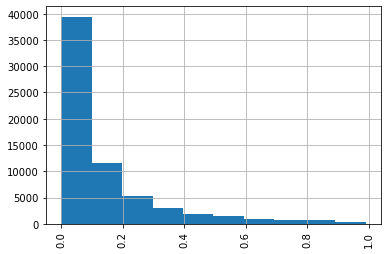

In [38]:
drug_mcg_kg_min = drug[(drug["drugname"] == "Norepinephrine (mcg/kg/min)")]
drug_mcg_kg_min["drugrate"] = drug_mcg_kg_min["drugrate"].astype("float")
drug_mcg_kg_min[drug_mcg_kg_min["drugrate"] < 1]["drugrate"].hist()
import matplotlib.pyplot as plt
plt.xticks(rotation=90)

<AxesSubplot:>

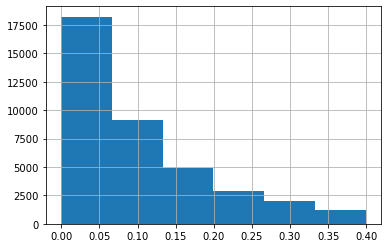

In [91]:
# I didnt solve hoe to do conversion

drug_mcg_min = drug[drug["drugname"] == "Norepinephrine (mcg/min)"]
drug_mcg_min = drug_mcg_min.drop(drug_mcg_min.index[186664])
drug_mcg_min["drugrate"] = drug_mcg_min["drugrate"].str.replace("Documentation undone", "0")
drug_mcg_min["drugrate"] = drug_mcg_min["drugrate"].astype(float)
drug_mcg_min["drugrate"] = drug_mcg_min["drugrate"] / drug_mcg_min["admissionweight"]
# print(drug_mcg_min["drugrate"].value_counts())
drug_mcg_min[drug_mcg_min["drugrate"] < 0.4]["drugrate"].hist(bins=6)
# plt.xticks(rotation=90)


In [ ]:
# # we want mcg/kg/min, here it is probably ml/mg/hr

# drug_ml_hr = drug[drug["drugname"] == "Norepinephrine (ml/hr)"]
# drug_ml_hr["drugrate"] = (drug_ml_hr["drugrate"].astype(float) * 1000)/(60 * drug_ml_hr["admissionweight"])
# drug_ml_hr[drug_ml_hr["drugrate"] < 0.3]["drugrate"].hist()

In [96]:
# combine
drugs_converted = pd.concat([drug_mcg_min, drug_mcg_kg_min])
drugs_converted = drugs_converted[["patientunitstayid", "infusionoffset", "drugrate"]]
decisions_after_pipeline = drugs_converted.rename(columns={"patientunitstayid":"stay_id", "infusionoffset":"starttime", "drugrate":"originalrate"})
decisions_after_pipeline["endtime"] = decisions_after_pipeline["starttime"]

In [97]:
bp_filtered = bp[bp["patientunitstayid"].isin(diagnosis_filtered["patientunitstayid"].unique())]
bp_filtered = bp_filtered[bp_filtered["patientunitstayid"].isin(drugs_converted["patientunitstayid"].unique())]
stay_ids = bp_filtered.groupby(by="patientunitstayid").agg({"systemicmean":"count"})
stay_ids_with_enough_events = stay_ids[stay_ids["systemicmean"] > 10].index
bp_filtered = bp_filtered[bp_filtered["patientunitstayid"].isin(stay_ids_with_enough_events)]

In [98]:
bp_filtered = bp_filtered[["patientunitstayid", "observationoffset", "systemicmean"]]
bp_filtered = bp_filtered.rename(columns={"patientunitstayid":"stay_id", "observationoffset": "cur_bp_time", "systemicmean":"cur_bp"})
bp_filtered.loc[(bp_filtered["cur_bp"] >= 200), "cur_bp"] = 199
bp_filtered.loc[(bp_filtered["cur_bp"] <= 0), "cur_bp"] = 0

In [99]:
from tqdm import tqdm
import numpy as np
# def doses_per_stay_id(stay_id, bps, doses):
#     bps_stay_id_subset = bps[bps.stay_id == stay_id]
#     doses_stay_id_subset = doses[doses.stay_id == stay_id]
#     bps_stay_id_subset = bps_stay_id_subset.sort_values(by="cur_bp_time")
#     bps_stay_id_subset["cur_avg_bp"] = bps_stay_id_subset["cur_bp"].rolling(3).mean()
#     bps_stay_id_subset["next_bp"] = bps_stay_id_subset["cur_bp"].shift(-1)
#     bps_stay_id_subset["next_bp_time"] = bps_stay_id_subset["cur_bp_time"].shift(-1)
#     bps_stay_id_subset["next_avg_bp"] = bps_stay_id_subset["next_bp"].rolling(3).mean().shift(-2)
#     if bps_stay_id_subset.shape[0] > 3:
#         bps_stay_id_subset["cur_avg_bp"].iloc[0] = bps_stay_id_subset["cur_bp"].iloc[0]
#         bps_stay_id_subset["cur_avg_bp"].iloc[1] =( bps_stay_id_subset["cur_bp"].iloc[0] + bps_stay_id_subset["cur_bp"].iloc[1])/2

#         bps_stay_id_subset["next_avg_bp"].iloc[-2] = bps_stay_id_subset["next_bp"].iloc[-2]
#         bps_stay_id_subset["next_avg_bp"].iloc[-3] = (bps_stay_id_subset["next_bp"].iloc[-3] + bps_stay_id_subset["next_bp"].iloc[-2])/2
    
    
#         bps_stay_id_subset["dose"] = np.nan
#         bps_stay_id_subset["dose"] = bps_stay_id_subset.apply(lambda row: match_dose(row, doses_stay_id_subset), axis=1)
#     return bps_stay_id_subset

# def match_dose(bp_row, doses):
#         relevant_doses = doses[(bp_row["cur_bp_time"] <= doses["starttime"]) & 
#                                     (bp_row["next_bp_time"] > doses["starttime"])]
#         dose = relevant_doses.head(1)[["originalrate", "starttime", "endtime"]]
#         if dose.size == 3:
#             return dose.values[0][0]
#         else:
#             return None
        
# def add_first_and_last_indicators(df):
#     # add first and last indicators
#     # sort by stay_id and cur_bp_time
#     df = df.sort_values(["stay_id", "cur_bp_time"], ascending=False)
#     df["last"] = df.groupby("stay_id").cumcount() == 0
#     df = df.sort_values(["stay_id", "cur_bp_time"], ascending=True)
#     df["first"] = df.groupby("stay_id").cumcount() == 0
#     return df

# def add_bp_catgeories(df):
#     # get bins for dose and bp
#     category_series= pd.cut(df.cur_bp, bins=BINS).astype(str)
#     # set name to category
#     category_series.name = "bp_category"
#     # add the category column to the df
#     df = df.join(category_series)
#     next_category_series= pd.cut(df.next_bp, bins=BINS).astype(str)
#     # set name to category
#     next_category_series.name = "next_bp_category"
#     df = df.join(next_category_series)
#     return df

In [200]:
stay_ids = decisions_after_pipeline.stay_id.unique() 
bps_and_dose = None
for stay_id in tqdm(stay_ids):
    bps_and_dose_per_stay = doses_per_stay_id(stay_id, bp_filtered , decisions_after_pipeline)
    if bps_and_dose is not None:
        bps_and_dose = pd.concat([bps_and_dose, bps_and_dose_per_stay],axis=0)
    else:
        bps_and_dose = bps_and_dose_per_stay

  0%|                                                                                         | 0/8322 [00:00<?, ?it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  0%|                                                                                 | 4/8322 [00:01<38:11,  3.63it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  0%|                                                       

  0%|▍                                                                             | 41/8322 [00:21<1:32:07,  1.50it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  1%|▍                                                                             | 43/8322 [00:22<1:25:56,  1.61it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  1%|▍                                                      

  1%|▋                                                                             | 78/8322 [00:46<1:21:41,  1.68it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  1%|▋                                                                             | 79/8322 [00:47<1:15:58,  1.81it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  1%|▋                                                      

  1%|▉                                                                            | 101/8322 [01:02<2:12:58,  1.03it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  1%|▉                                                                            | 103/8322 [01:03<1:57:13,  1.17it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  1%|▉                                                      

  2%|█▏                                                                           | 134/8322 [01:24<1:23:00,  1.64it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  2%|█▎                                                                           | 136/8322 [01:25<1:07:36,  2.02it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  2%|█▎                                                     

  2%|█▌                                                                           | 168/8322 [01:45<1:01:34,  2.21it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  2%|█▌                                                                           | 169/8322 [01:45<1:10:09,  1.94it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  2%|█▌                                                     

  2%|█▊                                                                           | 197/8322 [02:07<1:21:07,  1.67it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  2%|█▉                                                                             | 202/8322 [02:07<58:41,  2.31it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  2%|█▉                                                     

  3%|██                                                                           | 226/8322 [02:16<1:03:37,  2.12it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  3%|██▏                                                                            | 228/8322 [02:16<47:46,  2.82it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  3%|██                                                     

  3%|██▍                                                                          | 261/8322 [02:32<1:06:36,  2.02it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  3%|██▌                                                                            | 266/8322 [02:33<50:04,  2.68it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  3%|██▌                                                    

  4%|██▉                                                                          | 320/8322 [02:53<2:22:22,  1.07s/it]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  4%|██▉                                                                          | 322/8322 [02:55<2:11:50,  1.01it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  4%|██▉                                                    

  4%|███▍                                                                           | 366/8322 [03:16<34:23,  3.86it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  5%|███▋                                                                           | 388/8322 [03:16<11:49, 11.18it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\in

  9%|██████▊                                                                      | 737/8322 [04:11<1:20:04,  1.58it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  9%|██████▊                                                                      | 740/8322 [04:13<1:17:05,  1.64it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  9%|███████▏                                               

C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 12%|█████████▏                                                                     | 962/8322 [04:36<30:36,  4.01it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 12%|█████████▎                                                                     | 981/8322 [04:37<12:47,  9.56it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\in

C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 14%|███████████                                                                   | 1176/8322 [05:04<05:12, 22.83it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

 16%|████████████▏                                                                 | 1298/8322 [05:39<30:30,  3.84it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 16%|████████████▎                                                                 | 1315/8322 [05:41<13:31,  8.64it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 16%|████████████▍                                          

 17%|█████████████▍                                                                | 1437/8322 [06:11<57:40,  1.99it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 17%|█████████████▌                                                                | 1441/8322 [06:13<52:26,  2.19it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 18%|█████████████▋                                         

 19%|██████████████▋                                                               | 1572/8322 [06:35<07:47, 14.44it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 19%|██████████████▊                                                               | 1583/8322 [06:35<05:47, 19.41it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 19%|███████████████▏                                       

 21%|████████████████▍                                                             | 1755/8322 [06:58<15:35,  7.02it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 21%|████████████████▍                                                             | 1758/8322 [07:02<50:44,  2.16it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\in

 22%|█████████████████▍                                                            | 1863/8322 [07:22<26:30,  4.06it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 22%|█████████████████▍                                                            | 1866/8322 [07:23<28:03,  3.84it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 23%|█████████████████▌                                     

 24%|██████████████████▋                                                           | 2000/8322 [07:53<07:44, 13.60it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 24%|██████████████████▊                                                           | 2003/8322 [07:54<09:13, 11.42it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 24%|██████████████████▊                                    

 26%|████████████████████                                                          | 2136/8322 [08:14<15:35,  6.61it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 26%|████████████████████                                                          | 2139/8322 [08:14<16:45,  6.15it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 26%|████████████████████                                   

 27%|████████████████████▉                                                         | 2237/8322 [08:32<20:08,  5.03it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 27%|████████████████████▉                                                         | 2239/8322 [08:32<26:34,  3.81it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 27%|█████████████████████▏                                 

 28%|██████████████████████                                                        | 2360/8322 [09:01<20:07,  4.94it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 28%|██████████████████████▏                                                       | 2362/8322 [09:02<21:01,  4.72it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 28%|██████████████████████▏                                

 30%|███████████████████████                                                       | 2465/8322 [09:21<08:35, 11.37it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 30%|███████████████████████▎                                                      | 2483/8322 [09:22<05:30, 17.68it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 30%|███████████████████████▍                               

 31%|████████████████████████▎                                                     | 2592/8322 [09:40<10:51,  8.79it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 31%|████████████████████████▎                                                     | 2594/8322 [09:41<24:37,  3.88it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\in

 33%|█████████████████████████▍                                                    | 2713/8322 [09:58<16:55,  5.52it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 33%|█████████████████████████▋                                                    | 2734/8322 [10:00<06:00, 15.50it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 33%|█████████████████████████▊                             

 34%|██████████████████████████▍                                                   | 2825/8322 [10:15<18:30,  4.95it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 34%|██████████████████████████▍                                                   | 2827/8322 [10:16<26:32,  3.45it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 34%|██████████████████████████▋                            

C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 37%|████████████████████████████▊                                                 | 3072/8322 [10:45<23:49,  3.67it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 37%|████████████████████████████▊                                                 | 3077/8322 [10:46<16:05,  5.43it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\in

 39%|██████████████████████████████▎                                               | 3230/8322 [11:11<18:57,  4.48it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 39%|██████████████████████████████▍                                               | 3241/8322 [11:12<12:10,  6.96it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 39%|██████████████████████████████▍                        

 42%|████████████████████████████████▋                                             | 3485/8322 [11:54<28:04,  2.87it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 42%|████████████████████████████████▋                                             | 3487/8322 [11:56<46:14,  1.74it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 42%|████████████████████████████████▊                      

 43%|█████████████████████████████████▊                                            | 3608/8322 [12:22<08:27,  9.29it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 44%|█████████████████████████████████▉                                            | 3621/8322 [12:24<07:14, 10.82it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 44%|██████████████████████████████████                     

 45%|███████████████████████████████████                                           | 3744/8322 [12:43<17:48,  4.29it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 45%|███████████████████████████████████▏                                          | 3753/8322 [12:43<07:16, 10.47it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 45%|███████████████████████████████████▎                   

 47%|████████████████████████████████████▌                                         | 3899/8322 [13:09<04:07, 17.87it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 47%|████████████████████████████████████▌                                         | 3902/8322 [13:11<16:09,  4.56it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 47%|████████████████████████████████████▋                  

 49%|█████████████████████████████████████▉                                        | 4052/8322 [13:34<06:47, 10.47it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 49%|█████████████████████████████████████▉                                        | 4054/8322 [13:34<07:34,  9.38it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 49%|██████████████████████████████████████                 

 51%|███████████████████████████████████████▌                                      | 4223/8322 [14:03<04:52, 14.01it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 51%|███████████████████████████████████████▋                                      | 4228/8322 [14:04<10:21,  6.59it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\in

 53%|████████████████████████████████████████▉                                     | 4374/8322 [14:35<09:08,  7.20it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 53%|█████████████████████████████████████████                                     | 4383/8322 [14:39<15:20,  4.28it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 53%|█████████████████████████████████████████▍             

 54%|██████████████████████████████████████████▍                                   | 4533/8322 [14:59<03:30, 18.01it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 55%|██████████████████████████████████████████▌                                   | 4540/8322 [15:00<03:53, 16.19it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 55%|██████████████████████████████████████████▋            

 56%|███████████████████████████████████████████▉                                  | 4683/8322 [15:21<04:08, 14.65it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 56%|███████████████████████████████████████████▉                                  | 4688/8322 [15:22<11:55,  5.08it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 56%|███████████████████████████████████████████▉           

 58%|█████████████████████████████████████████████▎                                | 4831/8322 [15:47<10:35,  5.50it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 58%|█████████████████████████████████████████████▎                                | 4839/8322 [15:48<07:26,  7.80it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 58%|█████████████████████████████████████████████▍         

 60%|██████████████████████████████████████████████▊                               | 4990/8322 [16:12<03:06, 17.85it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 60%|██████████████████████████████████████████████▉                               | 5002/8322 [16:13<04:18, 12.84it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 60%|██████████████████████████████████████████████▉        

C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 62%|████████████████████████████████████████████████▎                             | 5161/8322 [16:38<15:39,  3.37it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 62%|████████████████████████████████████████████████▍                             | 5163/8322 [16:39<23:41,  2.22it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\in

 66%|███████████████████████████████████████████████████▋                          | 5516/8322 [17:27<03:19, 14.05it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 66%|███████████████████████████████████████████████████▋                          | 5521/8322 [17:30<15:48,  2.95it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 66%|███████████████████████████████████████████████████▊   

 69%|█████████████████████████████████████████████████████▊                        | 5748/8322 [18:10<32:53,  1.30it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 69%|█████████████████████████████████████████████████████▉                        | 5756/8322 [18:10<09:49,  4.35it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 69%|█████████████████████████████████████████████████████▉ 

 70%|██████████████████████████████████████████████████████▉                       | 5862/8322 [18:38<04:42,  8.70it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 70%|██████████████████████████████████████████████████████▉                       | 5864/8322 [18:39<07:38,  5.36it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 70%|██████████████████████████████████████████████████████▉

 71%|███████████████████████████████████████████████████████▋                      | 5942/8322 [19:03<10:29,  3.78it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 71%|███████████████████████████████████████████████████████▋                      | 5944/8322 [19:05<16:38,  2.38it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 71%|███████████████████████████████████████████████████████

 72%|████████████████████████████████████████████████████████▏                     | 5993/8322 [19:32<16:47,  2.31it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 72%|████████████████████████████████████████████████████████▏                     | 5994/8322 [19:33<15:21,  2.53it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 72%|███████████████████████████████████████████████████████

 73%|████████████████████████████████████████████████████████▌                     | 6040/8322 [20:14<27:27,  1.39it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 73%|████████████████████████████████████████████████████████▋                     | 6042/8322 [20:14<21:28,  1.77it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 73%|███████████████████████████████████████████████████████

 74%|█████████████████████████████████████████████████████████▊                    | 6163/8322 [20:40<03:27, 10.39it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 74%|█████████████████████████████████████████████████████████▊                    | 6169/8322 [20:41<04:28,  8.01it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 74%|███████████████████████████████████████████████████████

 76%|███████████████████████████████████████████████████████████                   | 6298/8322 [21:14<05:34,  6.05it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 76%|███████████████████████████████████████████████████████████                   | 6301/8322 [21:15<11:21,  2.97it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 76%|███████████████████████████████████████████████████████

 77%|███████████████████████████████████████████████████████████▊                  | 6381/8322 [21:44<07:35,  4.26it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 77%|███████████████████████████████████████████████████████████▊                  | 6385/8322 [21:44<05:22,  6.01it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 77%|███████████████████████████████████████████████████████

 78%|█████████████████████████████████████████████████████████████▏                | 6530/8322 [22:07<05:25,  5.51it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 79%|█████████████████████████████████████████████████████████████▎                | 6538/8322 [22:08<02:55, 10.16it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 79%|███████████████████████████████████████████████████████

 80%|██████████████████████████████████████████████████████████████▋               | 6688/8322 [22:36<04:35,  5.93it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 81%|███████████████████████████████████████████████████████████████               | 6732/8322 [22:41<01:53, 13.95it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 83%|███████████████████████████████████████████████████████

 84%|█████████████████████████████████████████████████████████████████▌            | 6994/8322 [23:35<21:35,  1.02it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 84%|█████████████████████████████████████████████████████████████████▌            | 6999/8322 [23:36<12:25,  1.78it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 84%|███████████████████████████████████████████████████████

 85%|██████████████████████████████████████████████████████████████████▎           | 7071/8322 [24:06<17:37,  1.18it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 85%|██████████████████████████████████████████████████████████████████▎           | 7077/8322 [24:07<07:41,  2.70it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 85%|███████████████████████████████████████████████████████

 86%|██████████████████████████████████████████████████████████████████▊           | 7126/8322 [24:29<09:30,  2.10it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 86%|██████████████████████████████████████████████████████████████████▊           | 7128/8322 [24:34<22:26,  1.13s/it]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 86%|███████████████████████████████████████████████████████

 86%|███████████████████████████████████████████████████████████████████▎          | 7177/8322 [25:07<11:17,  1.69it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 86%|███████████████████████████████████████████████████████████████████▎          | 7179/8322 [25:09<13:30,  1.41it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 86%|███████████████████████████████████████████████████████

 87%|███████████████████████████████████████████████████████████████████▋          | 7220/8322 [25:39<11:50,  1.55it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 87%|███████████████████████████████████████████████████████████████████▋          | 7221/8322 [25:43<29:56,  1.63s/it]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 87%|███████████████████████████████████████████████████████

 87%|████████████████████████████████████████████████████████████████████          | 7268/8322 [26:16<04:14,  4.14it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 87%|████████████████████████████████████████████████████████████████████▏         | 7272/8322 [26:17<03:20,  5.25it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 87%|███████████████████████████████████████████████████████

 88%|████████████████████████████████████████████████████████████████████▌         | 7321/8322 [26:50<11:25,  1.46it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 88%|████████████████████████████████████████████████████████████████████▋         | 7322/8322 [26:52<18:00,  1.08s/it]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 88%|███████████████████████████████████████████████████████

 89%|█████████████████████████████████████████████████████████████████████▎        | 7391/8322 [27:24<10:14,  1.52it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 89%|█████████████████████████████████████████████████████████████████████▎        | 7393/8322 [27:25<10:48,  1.43it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 89%|███████████████████████████████████████████████████████

 90%|█████████████████████████████████████████████████████████████████████▊        | 7453/8322 [27:47<07:01,  2.06it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 90%|█████████████████████████████████████████████████████████████████████▉        | 7459/8322 [27:47<02:42,  5.30it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 90%|███████████████████████████████████████████████████████

 90%|██████████████████████████████████████████████████████████████████████▍       | 7514/8322 [28:23<10:51,  1.24it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 90%|██████████████████████████████████████████████████████████████████████▍       | 7518/8322 [28:24<07:00,  1.91it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 90%|███████████████████████████████████████████████████████

 91%|██████████████████████████████████████████████████████████████████████▉       | 7567/8322 [28:46<12:07,  1.04it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 91%|██████████████████████████████████████████████████████████████████████▉       | 7568/8322 [28:46<10:47,  1.17it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 91%|███████████████████████████████████████████████████████

 92%|███████████████████████████████████████████████████████████████████████▍      | 7622/8322 [29:13<14:52,  1.27s/it]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 92%|███████████████████████████████████████████████████████████████████████▍      | 7627/8322 [29:14<06:28,  1.79it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 92%|███████████████████████████████████████████████████████

 92%|███████████████████████████████████████████████████████████████████████▉      | 7669/8322 [29:39<13:26,  1.23s/it]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 92%|███████████████████████████████████████████████████████████████████████▉      | 7670/8322 [29:40<10:22,  1.05it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 92%|███████████████████████████████████████████████████████

 93%|████████████████████████████████████████████████████████████████████████▏     | 7704/8322 [30:18<07:30,  1.37it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 93%|████████████████████████████████████████████████████████████████████████▎     | 7714/8322 [30:20<01:28,  6.88it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 93%|███████████████████████████████████████████████████████

 94%|█████████████████████████████████████████████████████████████████████████     | 7789/8322 [30:48<02:36,  3.41it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 94%|█████████████████████████████████████████████████████████████████████████     | 7791/8322 [30:54<10:06,  1.14s/it]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 94%|███████████████████████████████████████████████████████

 94%|█████████████████████████████████████████████████████████████████████████▍    | 7840/8322 [31:25<10:22,  1.29s/it]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 94%|█████████████████████████████████████████████████████████████████████████▌    | 7842/8322 [31:26<08:10,  1.02s/it]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 94%|███████████████████████████████████████████████████████

 95%|██████████████████████████████████████████████████████████████████████████    | 7904/8322 [32:24<05:13,  1.33it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 95%|██████████████████████████████████████████████████████████████████████████    | 7907/8322 [32:26<05:55,  1.17it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 95%|███████████████████████████████████████████████████████

 96%|██████████████████████████████████████████████████████████████████████████▌   | 7954/8322 [33:01<01:27,  4.20it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 96%|██████████████████████████████████████████████████████████████████████████▌   | 7959/8322 [33:04<02:54,  2.08it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 96%|███████████████████████████████████████████████████████

 96%|███████████████████████████████████████████████████████████████████████████   | 8013/8322 [33:29<01:55,  2.66it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 96%|███████████████████████████████████████████████████████████████████████████   | 8014/8322 [33:30<03:28,  1.48it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 96%|███████████████████████████████████████████████████████

 98%|████████████████████████████████████████████████████████████████████████████  | 8118/8322 [34:07<00:24,  8.37it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 98%|████████████████████████████████████████████████████████████████████████████▏ | 8129/8322 [34:08<00:21,  8.97it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 98%|███████████████████████████████████████████████████████

 98%|████████████████████████████████████████████████████████████████████████████▊ | 8195/8322 [34:39<01:07,  1.90it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 99%|████████████████████████████████████████████████████████████████████████████▊ | 8200/8322 [34:41<00:41,  2.95it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 99%|███████████████████████████████████████████████████████

 99%|█████████████████████████████████████████████████████████████████████████████▌| 8272/8322 [35:08<00:42,  1.19it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 99%|█████████████████████████████████████████████████████████████████████████████▌| 8273/8322 [35:10<00:51,  1.06s/it]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|███████████████████████████████████████████████████████

In [201]:
bps_and_dose = bps_and_dose[~bps_and_dose["cur_bp"].isna()]

In [202]:
BINS = pd.IntervalIndex.from_tuples([(0,50),(50,60),(60,65),(65,70),(70,75),(75,80),(80,90),(90,200)], closed="left")
BINS

IntervalIndex([[0, 50), [50, 60), [60, 65), [65, 70), [70, 75), [75, 80), [80, 90), [90, 200)],
              closed='left',
              dtype='interval[int64]')

In [203]:


bps_and_dose["dose"] = bps_and_dose["dose"].fillna(0)
bps_and_dose = add_first_and_last_indicators(bps_and_dose)


In [204]:
bps_and_dose = bps_and_dose.fillna(0)

In [205]:
bps_and_dose["cur_avg_bp"] = bps_and_dose["cur_avg_bp"].astype(int)
bps_and_dose["next_avg_bp"] = bps_and_dose["next_avg_bp"].astype(int)
bps_and_dose["cur_bp"] = bps_and_dose["cur_bp"].astype(int)
bps_and_dose["next_bp"] = bps_and_dose["next_bp"].astype(int)
bps_and_dose = bps_and_dose.drop(columns=["cur_avg_bp", "next_avg_bp"])
#bps_and_dose = bps_and_dose.rename(columns={"cur_avg_bp":"cur_bp", "next_avg_bp":"next_bp"})
bps_and_dose = add_bp_catgeories(bps_and_dose)

In [206]:
bps_and_dose_thresh = bps_and_dose

In [244]:
bps_and_dose_thresh = bps_and_dose_thresh[bps_and_dose_thresh["cur_bp"] < 140]
bps_and_dose_thresh = bps_and_dose_thresh[bps_and_dose_thresh["cur_bp"] > 20]

In [277]:
bps_and_dose_thresh.loc[bps_and_dose_thresh["dose"] >= 0.4, "dose"] = 0

<AxesSubplot:>

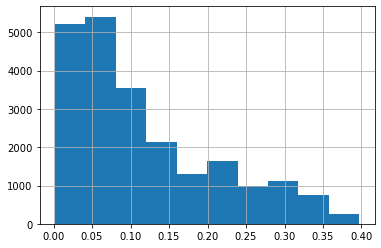

In [278]:
bps_and_dose_thresh[bps_and_dose_thresh["dose"] > 0]["dose"].hist()

In [279]:
bps_and_dose_thresh.to_csv("full_eICU_bps_with_doses_no_average.csv")

# MIMIC 8 bins


In [ ]:
mimic = pd.read_csv("../rnl/RNLData/MIMIC_bps_with_doses.csv")

In [ ]:
mimic["cur_bp"] = mimic["cur_bp"].astype(int)
mimic["next_bp"] = mimic["next_bp"].fillna(0).astype(int)

In [ ]:
mimic = mimic.drop(columns=["bp_category", "next_bp_category", "Unnamed: 0"])

In [ ]:
mimic_8_bins = add_bp_catgeories(mimic)

In [ ]:
mimic_8_bins.to_csv("../rnl/RNLData/MIMIC_bps_with_doses_8_bins.csv")